In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Author: harryyhwang
Date: 2024/11/26
Description: demo
"""

'\nAuthor: harryyhwang\nDate: 2024/11/26\nDescription: demo\n'

In [2]:
from dataclasses import dataclass
import argparse

@dataclass
class Config:
    device: str = 'cuda'
    vlm_model: str = 'gpt-4v'
    grounded_checkpoint: str = "ckpts/grounding-dino-base"
    depth_checkpoint: str = "local::/llm-cfs-nj/person/harryyhwang/ft_local/ft_local/ROOT/foundation/Depth_Anything/depth_anything_metric_depth_indoor.pt"
    box_threshold: float = 0.3
    iou_threshold: float = 0.5
    min_threshold: float = 0.15
    save_file: bool = False
    mask_filter: bool = False
    output_dir: str = 'outputs2'
    input_image: str = 'asset/0001682.jpg'
    prompt_dir: str = './prompt'
    sam_checkpoint: str = 'ckpts/sam-vit-huge'
    qwen_checkpoint: str = 'ckpts/Qwen2-VL-7B-FULL-full'
    phrase_simplify_checkpoint: str = 'ckpts/Qwen2.5-3B-Instruct'
    use_cache: bool = True

    @classmethod
    def from_args(cls):
        parser = argparse.ArgumentParser(description='Indoor Scene Pipeline')
        parser.add_argument('--device', type=str, default='cuda')
        parser.add_argument('--vlm_model', type=str, default='gpt-4v')
        parser.add_argument('--grounded_checkpoint', type=str, default="ckpts/grounding-dino-base")
        parser.add_argument('--depth_checkpoint', type=str, default="local::/llm-cfs-nj/person/harryyhwang/ft_local/ft_local/ROOT/foundation/Depth_Anything/depth_anything_metric_depth_indoor.pt")
        parser.add_argument('--box_threshold', type=float, default=0.3)
        parser.add_argument('--iou_threshold', type=float, default=0.5)
        parser.add_argument('--min_threshold', type=float, default=0.15)
        parser.add_argument('--save_file', action='store_true')
        parser.add_argument('--mask_filter', action='store_true')
        parser.add_argument('--output_dir', type=str, default='outputs')
        parser.add_argument('--input_image', type=str, default='asset/0001682.jpg')
        parser.add_argument('--prompt_dir', type=str, default='./prompt')
        parser.add_argument('--sam_checkpoint', type=str, default='ckpts/sam-vit-huge')
        parser.add_argument('--qwen_checkpoint', type=str, default='ckpts/Qwen2-VL-7B-FULL-full')
        parser.add_argument('--phrase_simplify_checkpoint', type=str, default='ckpts/Qwen2.5-3B-Instruct')
        parser.add_argument('--use_cache', action='store_true', default=True)
        
        args =parser.parse_known_args()[0]
        return cls(**vars(args)) 

config = Config.from_args()

Processing image: asset/0001682.jpg


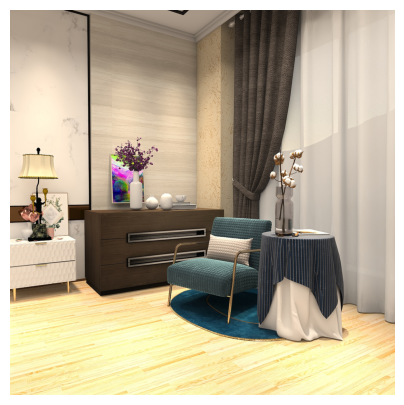

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import (
    get_file_list, 
    visualize_detections, 
    save_json,
    expand_box,
    calculate_iou,
    vlm_inference
)

image_paths = get_file_list(config.input_image)
test_image = image_paths[0]
print(f"Processing image: {test_image}")  # Changed from Chinese to English
plt.figure(figsize=(5, 5))
img = Image.open(test_image)
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
import cv2
import os, copy, time, tqdm, json
from foundation.detector import BoxDetector
from foundation.indoor_object import IndoorObjectDetector
from foundation.indoor_depth import IndoorDepthEstimator
from foundation.indoor_sam import IndoorSAMEstimator
from foundation.indoor_distance import IndoorDistanceEstimator

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
object_detector = IndoorObjectDetector(config)
output_dir = object_detector._prepare_output_dir(test_image)
container_caption = object_detector._load_container_caption(test_image)
print("Indoor objects and container：")
print(json.dumps(container_caption, indent=4, ensure_ascii=False))

Loading VLM model: gpt-4v
Loading model from IDEA-Research/grounding-dino-base
Indoor objects and container：
{
    "object1": {
        "description": "teal upholstered armchair",
        "container": "False"
    },
    "object2": {
        "description": "dark wooden sideboard",
        "container": "True"
    },
    "object3": {
        "description": "white round table with blue tablecloth",
        "container": "True"
    },
    "object4": {
        "description": "dark brown curtain",
        "container": "False"
    },
    "object5": {
        "description": "white sheer curtain",
        "container": "False"
    },
    "object6": {
        "description": "blue round rug",
        "container": "False"
    },
    "object7": {
        "description": "traditional table lamp",
        "container": "False"
    },
    "object8": {
        "description": "vase with purple flowers",
        "container": "False"
    },
    "object9": {
        "description": "white vase with cotton branch

Detection tags: teal upholstered armchair.dark wooden sideboard.white round table with blue tablecloth.dark brown curtain.white sheer curtain.blue round rug.traditional table lamp.vase with purple flowers.white vase with cotton branches.assorted decorative objects on sideboard.decorative pillow on armchair.books on round table
- Detected box: [0.543, 0.675, 0.276, 0.283], score: 0.866
- Detected box: [0.374, 0.626, 0.368, 0.235], score: 0.469
- Detected box: [0.756, 0.713, 0.231, 0.299], score: 0.884
- Detected box: [0.665, 0.275, 0.184, 0.541], score: 0.832
- Detected box: [0.847, 0.407, 0.299, 0.806], score: 0.500
- Detected box: [0.561, 0.789, 0.298, 0.146], score: 0.867
- Detected box: [0.074, 0.476, 0.111, 0.244], score: 0.844
- Detected box: [0.326, 0.422, 0.123, 0.192], score: 0.476
- Detected box: [0.327, 0.467, 0.039, 0.105], score: 0.529
- Detected box: [0.57, 0.621, 0.127, 0.091], score: 0.867


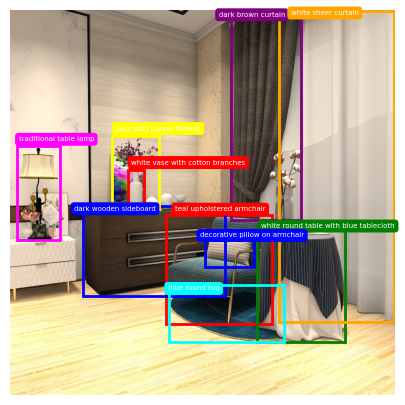


Detection results:
teal upholstered armchair: score=0.866, box=[485.71917724609375, 639.7559204101562, 817.500244140625, 979.6788330078125]
dark wooden sideboard: score=0.469, box=[227.6038818359375, 610.3035888671875, 669.7548217773438, 892.0487670898438]
white round table with blue tablecloth: score=0.884, box=[768.5404663085938, 676.0096435546875, 1045.295654296875, 1034.7120361328125]
dark brown curtain: score=0.832, box=[687.377197265625, 4.930206298828125, 907.63037109375, 654.1107177734375]
white sheer curtain: score=0.500, box=[837.2852783203125, 4.1689453125, 1195.7149658203125, 971.9149780273438]
blue round rug: score=0.867, box=[494.3901062011719, 858.7824096679688, 852.1058349609375, 1033.9556884765625]
traditional table lamp: score=0.844, box=[22.971900939941406, 424.9540710449219, 155.73516845703125, 717.47119140625]
vase with purple flowers: score=0.476, box=[317.8478088378906, 391.3770751953125, 465.330810546875, 621.36669921875]
white vase with cotton branches: score=

In [6]:
# Extract text descriptions from container descriptions
text_descriptions = [details['description'].replace(".", "").lower() for details in container_caption.values() if 'description' in details]
container_attribute = [details['container'].replace(".", "") == "True" for details in container_caption.values() if 'container' in details]
tags = ".".join(text_descriptions)

print("Detection tags:", tags)

# First round detection
boxes, scores, pred_phrases, unconverted_boxes = object_detector.box_detector.detect(tags=tags, image_path=test_image)

# Set save_file=False
visualize_detections(
    image_path=test_image,
    boxes=boxes,
    pred_phrases=pred_phrases,
    output_dir="tmp_visualization",  # This parameter is passed but won't be used
    flag="first_round",
    save_file=False
)

print("\nDetection results:")
for box, score, phrase in zip(boxes, scores, pred_phrases):
    print(f"{phrase}: score={score:.3f}, box={box.tolist()}")

Processing sub-object detection

Processing container: dark wooden sideboard

Sub-object descriptions for container dark wooden sideboard:
{
  "object1": {
    "description": "white vase with narrow top"
  },
  "object2": {
    "description": "small white spherical vase"
  },
  "object3": {
    "description": "tall white cylindrical vase"
  },
  "object4": {
    "description": "white oval-shaped small vase"
  },
  "object5": {
    "description": "colorful abstract framed artwork"
  }
}

Sub-object detection tags: white vase with narrow top.small white spherical vase.tall white cylindrical vase.white oval-shaped small vase.colorful abstract framed artwork
- Detected box: [0.559, 0.136, 0.062, 0.13], score: 0.379
- Detected box: [0.626, 0.113, 0.055, 0.058], score: 0.370
- Detected box: [0.416, 0.102, 0.064, 0.201], score: 0.646
- Detected box: [0.49, 0.139, 0.063, 0.113], score: 0.403
- Detected box: [0.378, 0.078, 0.167, 0.155], score: 0.474

Sub-objects detected in container dark wood

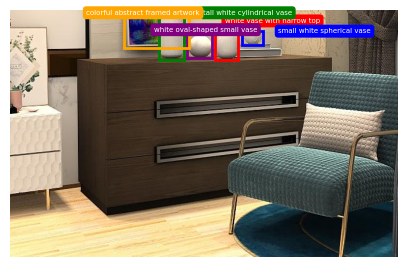

- white vase with narrow top: score=0.379, box=[467.14990234375, 569.2560424804688, 507.952392578125, 624.1428833007812]
- small white spherical vase: score=0.370, box=[513.8375244140625, 574.8262329101562, 550.4059448242188, 599.1812133789062]
- white oval-shaped small vase: score=0.403, box=[420.97210693359375, 574.0192260742188, 462.83599853515625, 621.934326171875]
- colorful abstract framed artwork: score=0.474, box=[312.088623046875, 539.3942260742188, 422.5356140136719, 604.9596557617188]
Successfully added 4 sub-objects

Processing container: white round table with blue tablecloth

Sub-object descriptions for container white round table with blue tablecloth:
{
  "object1": {
    "description": "clear glass bottle with contents"
  },
  "object2": {
    "description": "white ceramic plate with food"
  },
  "object3": {
    "description": "metal fork beside plate"
  }
}

Sub-object detection tags: clear glass bottle with contents.white ceramic plate with food.metal fork beside pla

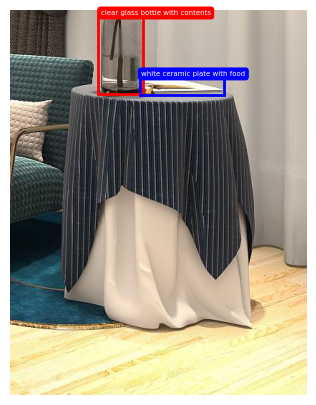

- clear glass bottle with contents: score=0.925, box=[822.5842895507812, 586.5609130859375, 885.9849243164062, 703.330322265625]
- white ceramic plate with food: score=0.614, box=[880.5009155273438, 678.5414428710938, 997.3339233398438, 704.8633422851562]
Successfully added 2 sub-objects

Displaying final detection results:


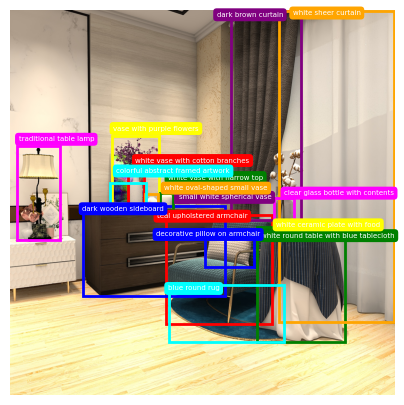

In [7]:
remain_index = [i for i, elem in enumerate(text_descriptions) if elem in pred_phrases]
container_attribute = [container_attribute[i] for i in remain_index]
copy_boxes, copy_phrase = copy.deepcopy(boxes), copy.deepcopy(pred_phrases)

print("="*50 + "\nProcessing sub-object detection\n" + "="*50)

# Create temporary directory
tmp_dir = os.path.join(output_dir, "temp")
os.makedirs(tmp_dir, exist_ok=True)

# Read original image
image_raw = Image.open(test_image).convert("RGB")

# Process each container
for b, phrase, contain_item in zip(copy_boxes, copy_phrase, container_attribute):
    if not contain_item:
        continue
        
    print(f"\nProcessing container: {phrase}")
    
    # Expand bounding box and crop container image
    b = expand_box(image_raw.size[1], image_raw.size[0], [i.item() for i in b])
    container_image = image_raw.crop(b)
    container_path = f"{tmp_dir}/temp_container_{phrase}.jpg"
    container_image.save(container_path)
    
    # Get sub-object descriptions
    sub_res = object_detector._sub_object_captioning(container_path, container=phrase)
    
    if "-1" in sub_res:
        print(f"No sub-objects detected in container {phrase}")
        continue
    
    try:
        sub_res = json.loads(sub_res)
        print(f"\nSub-object descriptions for container {phrase}:")
        print(json.dumps(sub_res, indent=2, ensure_ascii=False))
    except json.JSONDecodeError:
        print(f"Failed to parse sub-object descriptions for container {phrase}")
        continue
    
    # Process sub-objects
    sub_objects = [details['description'].replace(".", "") for details in sub_res.values() if 'description' in details]
    sub_tags = ".".join(sub_objects)
    
    print(f"\nSub-object detection tags: {sub_tags}")
    
    # Detect sub-objects
    sub_boxes, sub_scores, sub_phrases, _ = object_detector.box_detector.detect(
        tags=sub_tags,
        image_path=container_path,
        existing_boxes=copy.deepcopy(unconverted_boxes)
    )
    
    # Visualize detection results for current container
    if len(sub_boxes) > 0:
        print(f"\nSub-objects detected in container {phrase}:")
        visualize_detections(
            image_path=container_path,
            boxes=sub_boxes,
            pred_phrases=sub_phrases,
            output_dir=tmp_dir,
            flag=f'sub_objects_{phrase}',
            save_file=False
        )
    
    # Add valid sub-objects to results
    added_count = 0
    for sub_b, sub_s, sub_p in zip(sub_boxes, sub_scores, sub_phrases):
        sub_b[[0,2]] += b[0]
        sub_b[[1,3]] += b[1]
        if calculate_iou(sub_b, boxes, threshold=object_detector.config.iou_threshold):
            boxes.append(sub_b)
            scores.append(sub_s)
            pred_phrases.append(sub_p)
            added_count += 1
            print(f"- {sub_p}: score={sub_s:.3f}, box={sub_b.tolist()}")
    
    print(f"Successfully added {added_count} sub-objects")

# Display final detection results
print("\nDisplaying final detection results:")
visualize_detections(
    image_path=test_image,
    boxes=boxes,
    pred_phrases=pred_phrases,
    output_dir=tmp_dir,
    flag='final_result',
    save_file=False
)

# Clean up temporary files
import shutil
if os.path.exists(tmp_dir):
    shutil.rmtree(tmp_dir)


                                Detection Results Summary                                 
No.      Object                                  Confidence    Position [x1, y1, x2, y2]          
------------------------------------------------------------------------------------------
1       clear glass bottle with contents        0.925        [822.6, 586.6, 886.0, 703.3]       
2       white round table with blue tablecloth  0.884        [768.5, 676.0, 1045.3, 1034.7]     
3       blue round rug                          0.867        [494.4, 858.8, 852.1, 1034.0]      
4       decorative pillow on armchair           0.867        [607.6, 690.5, 760.4, 800.0]       
5       teal upholstered armchair               0.866        [485.7, 639.8, 817.5, 979.7]       
6       traditional table lamp                  0.844        [23.0, 425.0, 155.7, 717.5]        
7       dark brown curtain                      0.832        [687.4, 4.9, 907.6, 654.1]         
8       white ceramic plate with food  

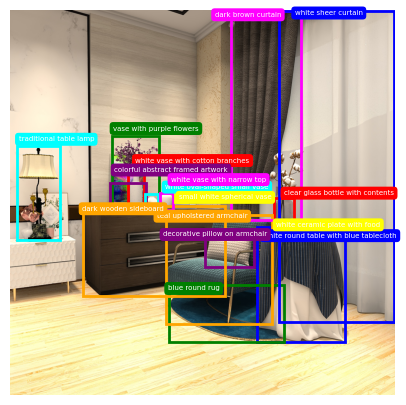

In [8]:
# Display detailed information for all detection results
print("\n" + "="*90)
print("Detection Results Summary".center(90))
print("="*90)

# Sort by confidence score
detection_results = sorted(zip(pred_phrases, scores, boxes), key=lambda x: x[1], reverse=True)

# Print header
print("No.      Object                                  Confidence    Position [x1, y1, x2, y2]          ")
print("-"*90)

# Print each result
for idx, (phrase, score, box) in enumerate(detection_results, 1):
    box_str = f"[{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]"
    print(f"{idx:<8}{phrase:<40}{score:.3f}{' '*8}{box_str:<35}")

print("-"*90)
print(f"Total objects detected: {len(detection_results)}\n")

# Visualize results
print("Final detection visualization:")
visualize_detections(
    image_path=test_image,
    boxes=[box for _, _, box in detection_results],
    pred_phrases=[phrase for phrase, _, _ in detection_results],
    output_dir="tmp",
    flag='final_summary',
    save_file=False
)

## Depth Anything

In [9]:
# Initialize depth estimator
depth_estimator = IndoorDepthEstimator(config)

Loading depth estimation model...


xFormers not available
xFormers not available


Using pretrained resource local::/mnt/d/ROOT/foundation/Depth_Anything/depth_anything_metric_depth_indoor.pt
Loaded successfully


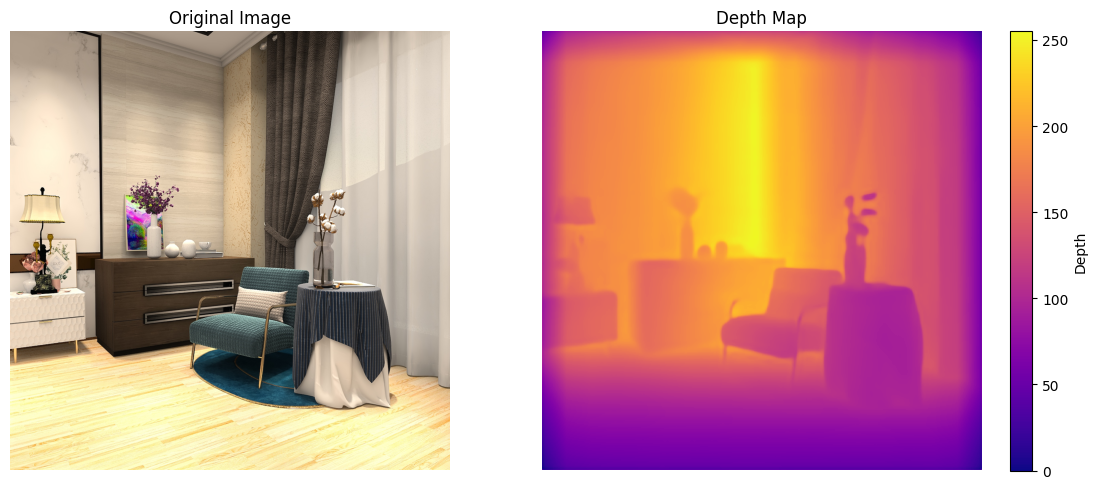

In [10]:
# Get depth map
depth_map_norm, metric_depth = depth_estimator.process_image(test_image)

# Visualize depth map
plt.figure(figsize=(12, 5))

# Original image
plt.subplot(121)
img = Image.open(test_image)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Depth map
plt.subplot(122)
plt.imshow(depth_map_norm, cmap='plasma')  # plasma colormap works well for depth visualization
plt.colorbar(label='Depth')
plt.title("Depth Map")
plt.axis('off')

plt.tight_layout()
plt.show()

## Segment Anything

In [11]:
# Initialize SAM estimator
sam_estimator = IndoorSAMEstimator(config)

Loading SAM model...


Processing SAM segmentation...


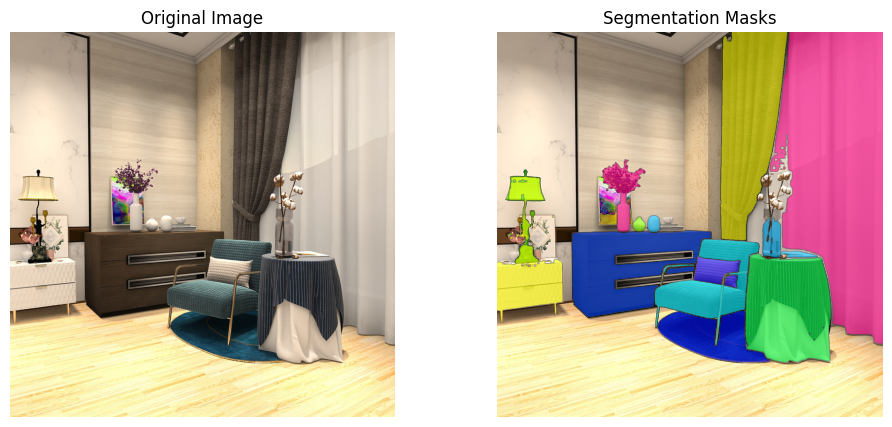


Successfully segmented 15 objects


In [12]:
# Segment detected objects
print("Processing SAM segmentation...")
masks, selected_idx = sam_estimator.process_image(test_image, boxes)

# Update boxes and pred_phrases to match selected masks
boxes = [boxes[i] for i in selected_idx]
pred_phrases = [pred_phrases[i] for i in selected_idx]
masks = [masks[i] for i in selected_idx]

# Visualize segmentation results
plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace=0.1)

# Left plot: Original image
plt.subplot(121)
img = Image.open(test_image).convert("RGB")
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Right plot: Segmentation results
plt.subplot(122)
plt.imshow(img)  # Show original image as background
# Overlay all masks
for mask in masks:
    sam_estimator._show_mask(mask, plt.gca(), random_color=True)
plt.title("Segmentation Masks")
plt.axis('off')

plt.show()

print(f"\nSuccessfully segmented {len(masks)} objects")

## Distance Estimator

In [13]:
# Initialize distance estimator
distance_estimator = IndoorDistanceEstimator(config)

Processing distance estimation...


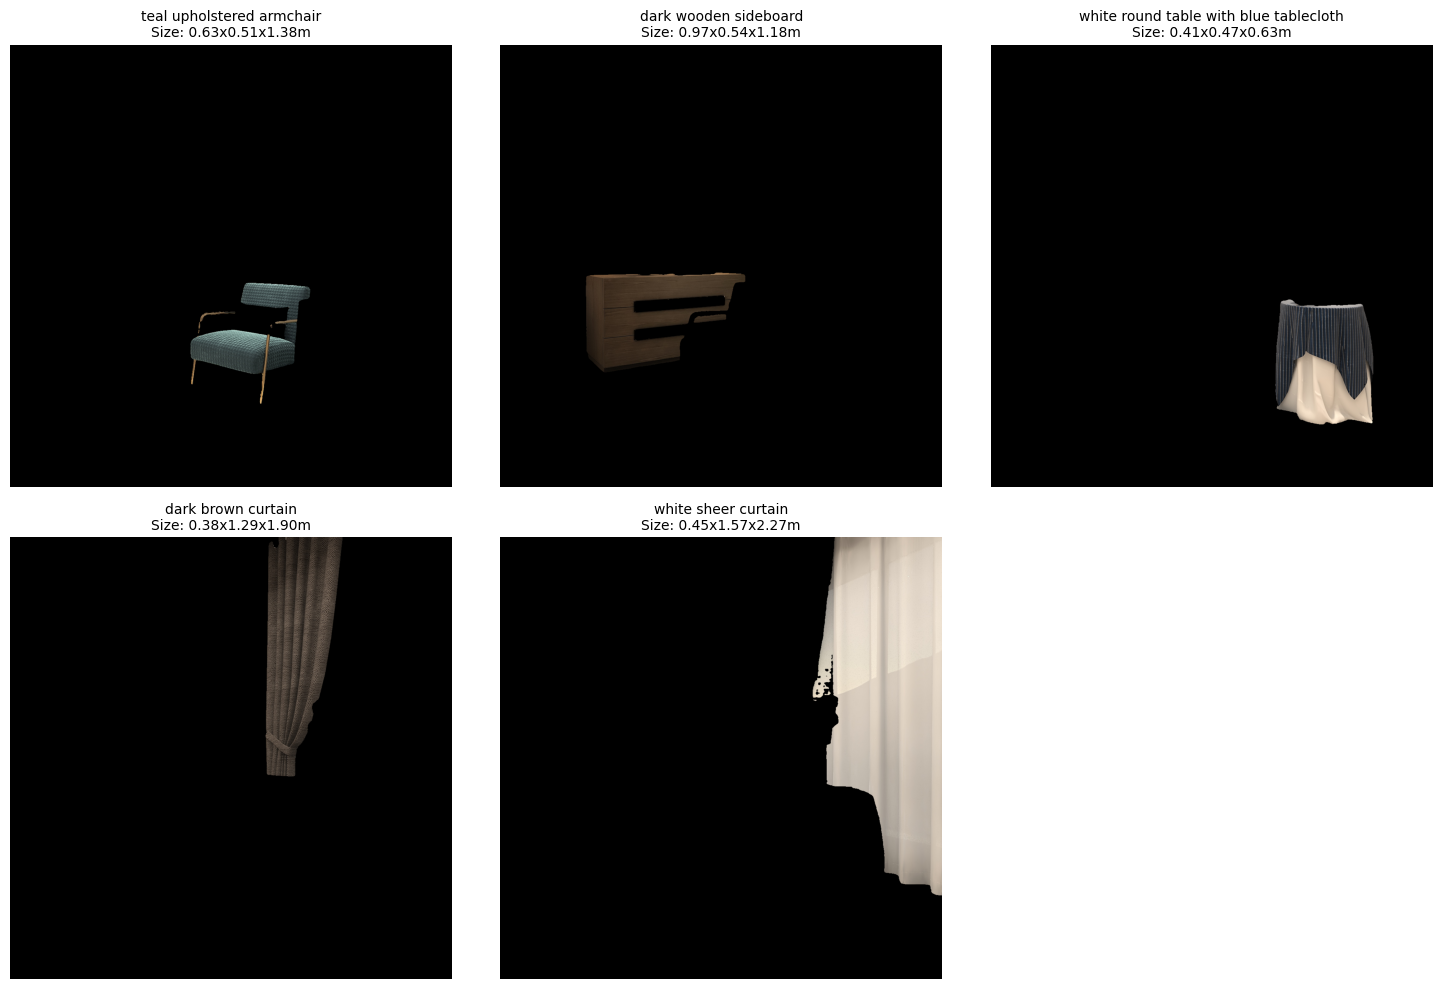


Displayed 5 segmented objects


In [15]:
import cv2

# Process image to get relative positions, point clouds, colors and size information
print("Processing distance estimation...")
relative_positions, point_clouds, colors, sizes = distance_estimator.process_image(
    test_image, masks, pred_phrases, metric_depth
)

# Show segmentation images for first 5 objects
num_objects = min(5, len(masks))
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

# Calculate number of rows and columns
n_cols = 3
n_rows = (num_objects + n_cols - 1) // n_cols

for i in range(num_objects):
    plt.subplot(n_rows, n_cols, i+1)
    img = cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB)
    masked_img = distance_estimator._apply_mask_to_image(img, masks[i])
    plt.imshow(masked_img)
    plt.title(f"{pred_phrases[i]}\nSize: {sizes[i][0]:.2f}x{sizes[i][1]:.2f}x{sizes[i][2]:.2f}m", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\nDisplayed {num_objects} segmented objects")